# Arrhythmia Classifier
<small>By Jorge Alarcón and Dante Mújica</small>
<h4>Abstract</h4>
<p>In this notebook, I will show how to use the <b><i>mitbih_processor</b></i> Python package to extract <b><i>"QRS Intervals"</b></i> from the <a href="https://physionet.org/content/mitdb/1.0.0/">Physionet MIT-BIH Arrhythmia Database</a>. After that, I will apply feature extraction to the QRS Intervals (signals) using Wavelet signal decomposition with different Wavelet families, and finally, I will use different classifiers to make a comparison.</p>

### QRS Interval Extraction
<h4>What is a QRS Interval?</h4>
<p>This work is based on example 4.8 of chapter 4 of the book <i>"Practical Machine Learning for Data Analysis Using Python"</i> by Dr. Abdulhamit Subasi. In that example, the ECG signals come from a file called MITBIH_ECG.mat, that Matlab file contains 5 variables: ECGN, ECGAPC, ECGPVC, ECGLBBB, and ECGRBBB. Each of these variables contains a matrix where the columns represent the signals. Each signal is a segment of 320 samples from an original record in the MIT-BIH Arrhythmia Database. ECGN contains segments of the signals that were annotated with N (Normal beat), ECGAPC contains segments of the signals that were annotated with A (Atrial premature beat), ECGPVC contains segments of the signals that were annotated with V (Premature ventricular contraction), ECGLBBB contains segments of the signals that were annotated with L (Left bundle branch block beat) and ECGRBBB contains segments of the signals that were annotated with R (Right bundle branch block beat). If you want to see the documentation of the MIT-BIH Arrhythmia Database to see what the annotations mean, you can visit the following <a href="https://archive.physionet.org/physiobank/annotations.shtml">link</a>.

I call "QRS Interval" to these signal segments, mainly because they contain a QRS complex in the center of the signal. I will plot some of the signals in the MITBIH_ECG.mat so you can have a better understanding.
</p>

In [1]:
# Import the required libraries
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the MITBIH_ECG.mat file
ECG_signals = sio.loadmat('data/MITBIH_ECG.mat')
N_signals = ECG_signals['ECGN']
A_signals = ECG_signals['ECGAPC']
V_signals = ECG_signals['ECGPVC']
L_signals = ECG_signals['ECGLBBB']
R_signals = ECG_signals['ECGRBBB']

In [3]:
# Describe the signals
print('As I said before, the matrix contains signals as columns')
print('Shape of the ECGN matrix:', N_signals.shape)
print('ECG contains 1000 signals, each one of 320 samples')

As I said before, the matrix contains signals as columns
Shape of the ECGN matrix: (320, 1000)
ECG contains 1000 signals, each one of 320 samples


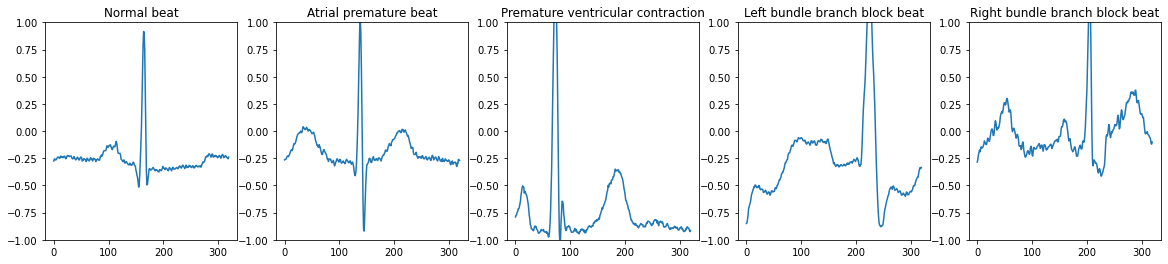

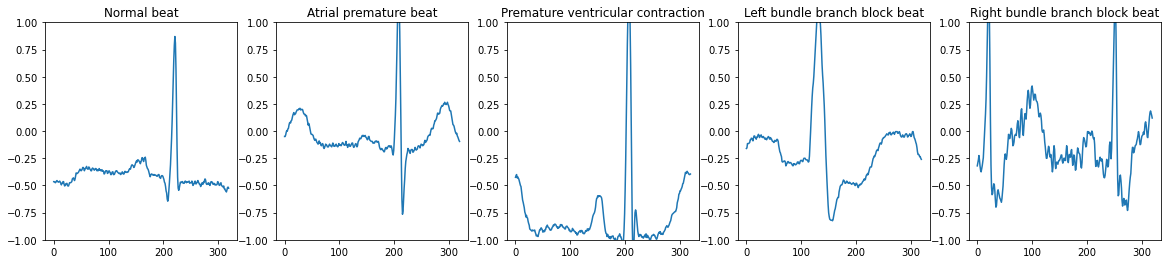

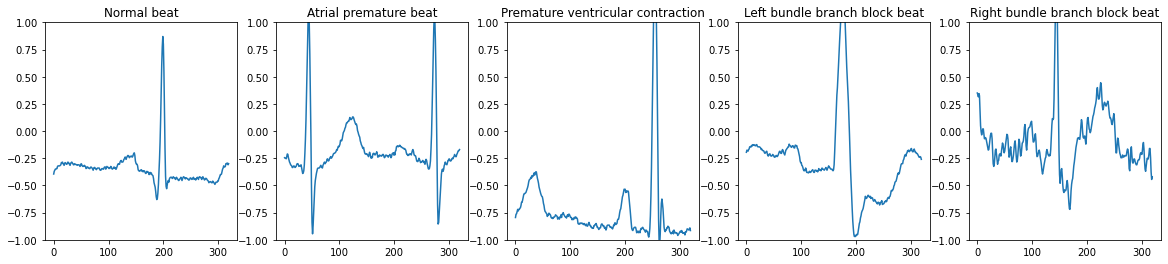

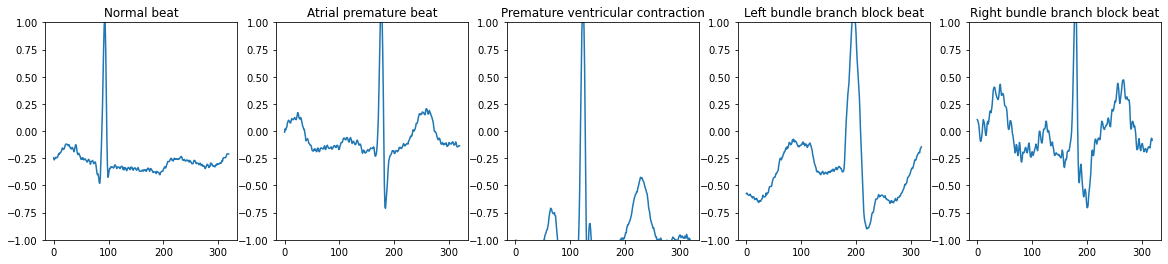

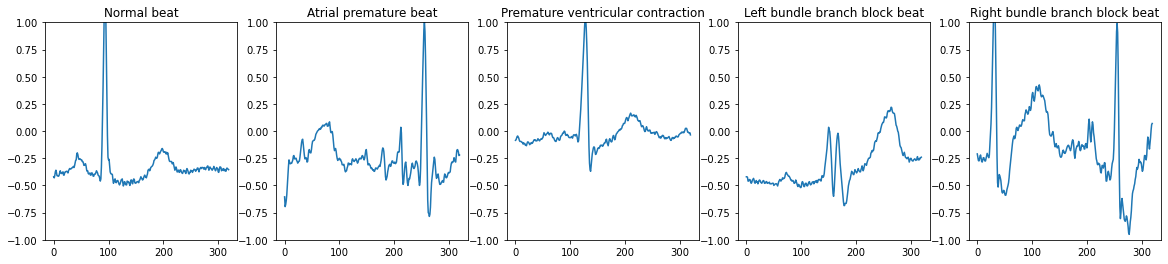

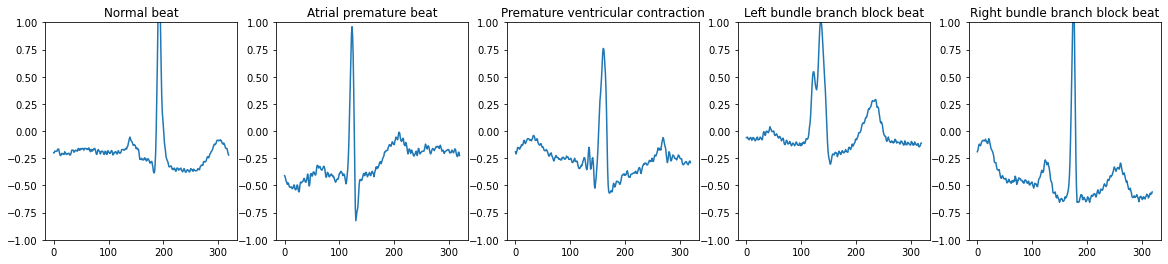

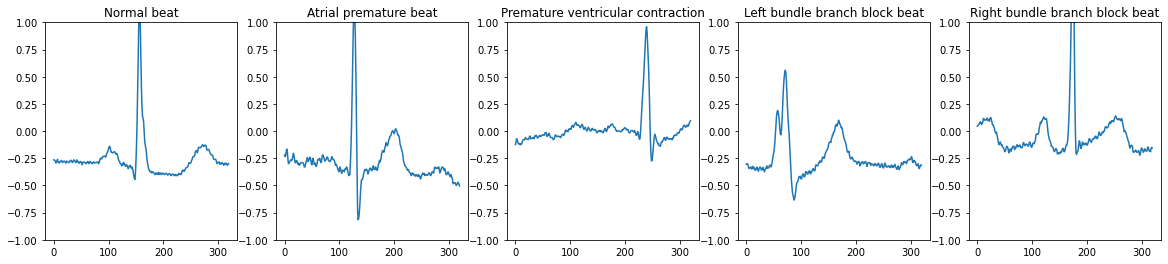

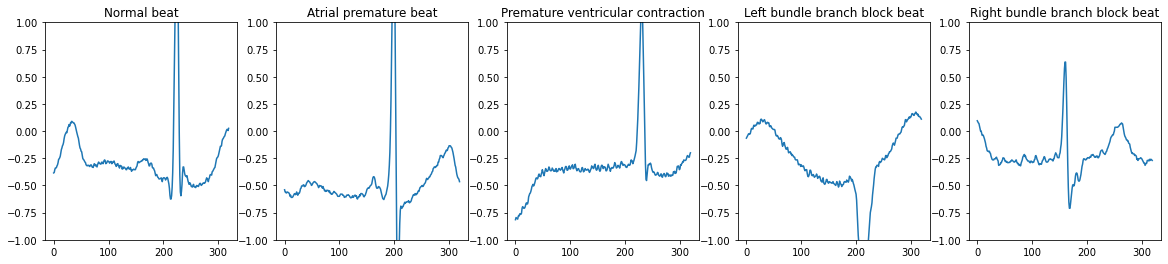

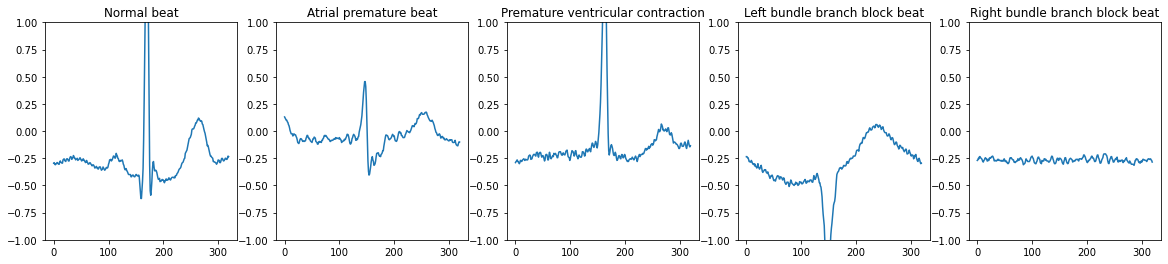

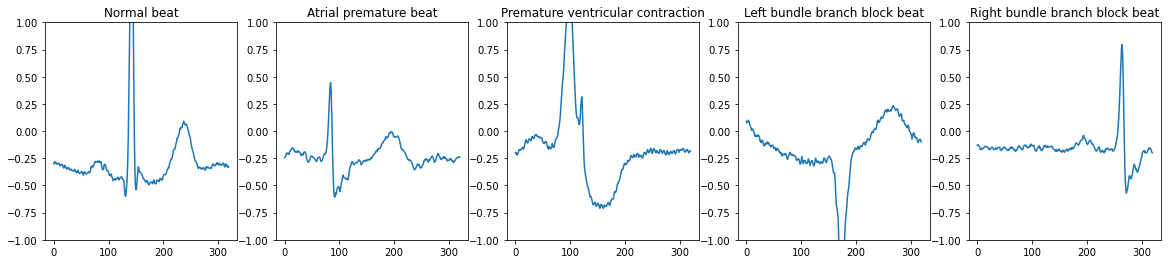

In [4]:
# Plot the signals
x = range(0, 320)
for i in range(0, 300, 30):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))    
    ax1.set_title('Normal beat')
    ax1.plot(x, N_signals[:, i])
    ax1.set_ylim([-1, 1])
    ax2.set_title('Atrial premature beat')
    ax2.plot(x, A_signals[:, i])
    ax2.set_ylim([-1, 1])
    ax3.set_title('Premature ventricular contraction')
    ax3.plot(x, V_signals[:, i])    
    ax3.set_ylim([-1, 1])
    ax4.set_title('Left bundle branch block beat')
    ax4.plot(x, L_signals[:, i])
    ax4.set_ylim([-1, 1])    
    ax5.set_title('Right bundle branch block beat')
    ax5.plot(x, R_signals[:, i])
    ax5.set_ylim([-1, 1])    
    plt.show()

<p>The process of generating the MITBIH_ECG.mat was not documented, so in order to extract the same information from the records in the MIT-BIH Arrhythmia Database, I developed a Python module (<b><i>mitbih_processor.qrsintervals</i></b>) that extracts those "QRS Intervals" and saves them in a .mat file.</p>
<h4>Using <b><i>mitbih_processor.qrsintervals</i></b> to extract the data</h4>
<p>With the <b><i>mitbih_processor.qrsintervals</i></b> extracting the QRS Intervals from the records of the MIT-BIH Arrhythmia Database is easy, but first, you have to define the following extraction parameters:</p>
<ul>
    <li><b>MIT-BIH Arrhythmia Database path:</b> the location of the MIT-BIH Database in your file system.</li>
    <li><b>Resulting .mat file path:</b> the file name where the signals will be saved.</li>
    <li><b>Annotations:</b> the annotation labels that you want to extract (A, N, L, etc.).</li>
    <li><b>Records to extract:</b> a list of the MIT-BIH Database records of which the signals will be extracted.</li>
    <li><b>ECG lead:</b> the ECG lead of the signals (MLII, V1, V5, etc).</li>
    <li><b>Start sample index:</b> the entire signals in the MIT-BIH Arrhythmia Database have a length of 650,000 samples, this parameter is the starting sample number to read the signal.</li>
    <li><b>End sample index:</b> the sample number at which to stop reading the signal.</li>
    <li><b>QRS Interval length: </b>this is the length of the QRS Intervals, Dr. Abdulhamit Subasi used a length of 320 samples in his example.</li>
</ul>

<p>In this example I will read the signals from the ECG lead MLII, the annotations will be A, V, N, L, and R, I will read the entire signal so the starting sample will be 0 and the end sample will be 650,000. I also want a QRS interval length of 320 samples, and lastly, I will use the datasets proposed by de Chazal, in his paper <i>Automatic classification of heartbeats using ECG morphology and heartbeat interval features</i>.</p>

In [5]:
# Import the modules
from mitbih_processor import qrsintervals
from mitbih_processor.datasets import CHAZAL_TEST_DATASET, CHAZAL_TRAIN_DATASET

# Define the extraction parameters
mitdbih_db_path = '/home/jorge4larcon/Projects/Tesina/research/notebooks/datasets/ultimate-mitdb/'
mat_file = 'data/ecg_signals.mat'
annotations = 'A', 'V', 'N', 'L', 'R'
records_to_extract = CHAZAL_TEST_DATASET + CHAZAL_TRAIN_DATASET
start_sample_index = 0
end_sample_index = 650_000
qrs_interval_length = 320
ecg_lead = 'MLII'

# Extract the signals and save them to a .mat file
qrsintervals.extract_qrs_intervals_and_save(
    mitdbih_db_path,                       # MIT-BIH Arrhythmia Database path
    mat_file,                              # Resultig .mat file path
    annotations,                           # Annotations
    lead=ecg_lead,                         # ECG lead
    sampfrom=start_sample_index,           # Start sample index
    sampto=end_sample_index,               # End sample index
    dataset=records_to_extract,            # Records to extract
    interval_length=qrs_interval_length    # QRS Interval length
)

Extracting QRS intervals for labels A, V, N, L, R
Extracting QRS intervals from record 100
 - Label A, 33 item(s)
 - Label V, 1 item(s)
Could not cut RR interval from QRS index 76
Could not cut RR interval from QRS index 649992
 - Label N, 2237 item(s)
 - Label L, 0 item(s)
 - Label R, 0 item(s)
Extracting QRS intervals from record 103
 - Label A, 2 item(s)
 - Label V, 0 item(s)
Could not cut RR interval from QRS index 649875
 - Label N, 2081 item(s)
 - Label L, 0 item(s)
 - Label R, 0 item(s)
Extracting QRS intervals from record 105
 - Label A, 0 item(s)
 - Label V, 41 item(s)
 - Label N, 2526 item(s)
 - Label L, 0 item(s)
 - Label R, 0 item(s)
Extracting QRS intervals from record 111
 - Label A, 0 item(s)
 - Label V, 1 item(s)
 - Label N, 0 item(s)
 - Label L, 2123 item(s)
 - Label R, 0 item(s)
Extracting QRS intervals from record 113
 - Label A, 0 item(s)
 - Label V, 0 item(s)
Could not cut RR interval from QRS index 649994
 - Label N, 1788 item(s)
 - Label L, 0 item(s)
 - Label R, 

 - Label A, 72 item(s)
 - Label V, 473 item(s)
Could not cut RR interval from QRS index 649850
 - Label N, 2028 item(s)
 - Label L, 0 item(s)
 - Label R, 0 item(s)
Extracting QRS intervals from record 230
 - Label A, 0 item(s)
 - Label V, 1 item(s)
Could not cut RR interval from QRS index 75
 - Label N, 2254 item(s)
 - Label L, 0 item(s)
 - Label R, 0 item(s)
Summary of extracted signals from MIT-BIH Arrhythmia Database:
 -> A interval(s): 2546
 -> V interval(s): 6902
 -> N interval(s): 74512
 -> L interval(s): 8072
 -> R interval(s): 7257
Saving signals in data/ecg_signals.mat


<p>Above you can see a report of the signals extracted. These signals were stored in a .mat file, this file contains the variables A, V, N, L, and R, because I specified those annotations for the extraction. The signals are stored in a matrix, but in this case, they are rows, not columns. Now I will plot the extracted signals so you can compare them with the signals in MITBIH_ECG.mat.</p>


In [6]:
# Import the required libraries
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# Load the ecg_signals.mat file
ECG_signals = sio.loadmat('data/ecg_signals.mat')
N_signals = ECG_signals['N']
A_signals = ECG_signals['A']
V_signals = ECG_signals['V']
L_signals = ECG_signals['L']
R_signals = ECG_signals['R']

In [8]:
# Describe the signals
print('As I said before, the matrix contains signals as rows')
print('Shape of the ECGN matrix:', N_signals.shape)
print('N contains 74512 signals, each one of 320 samples')

As I said before, the matrix contains signals as rows
Shape of the ECGN matrix: (74512, 320)
N contains 74512 signals, each one of 320 samples


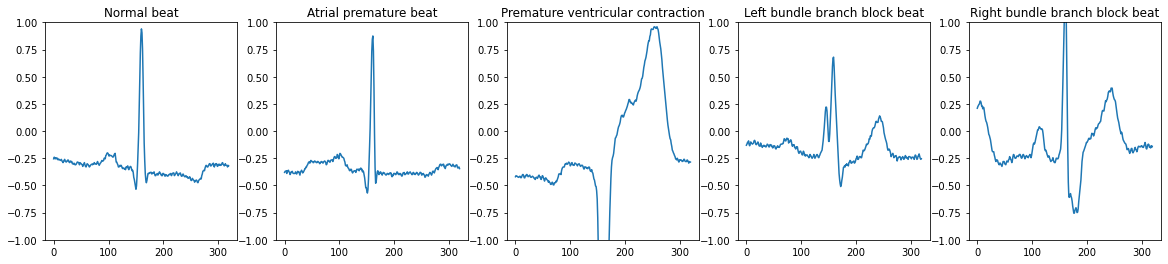

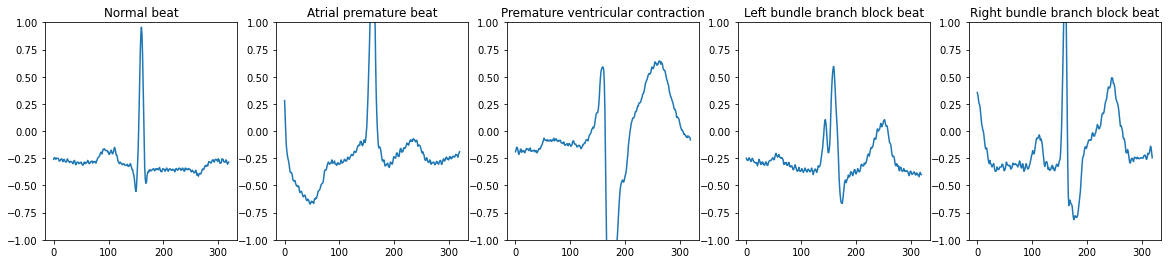

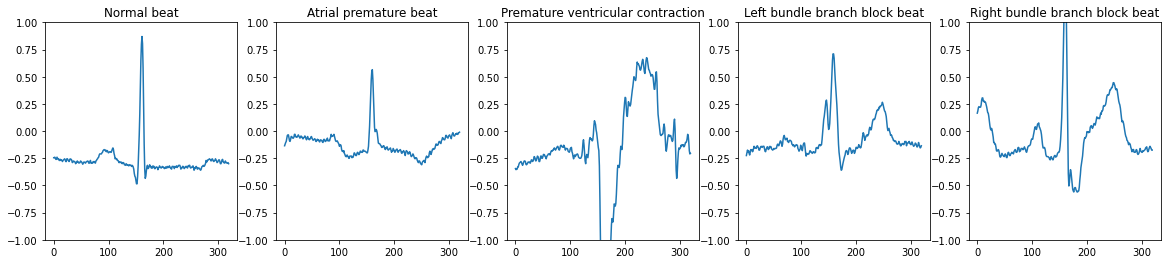

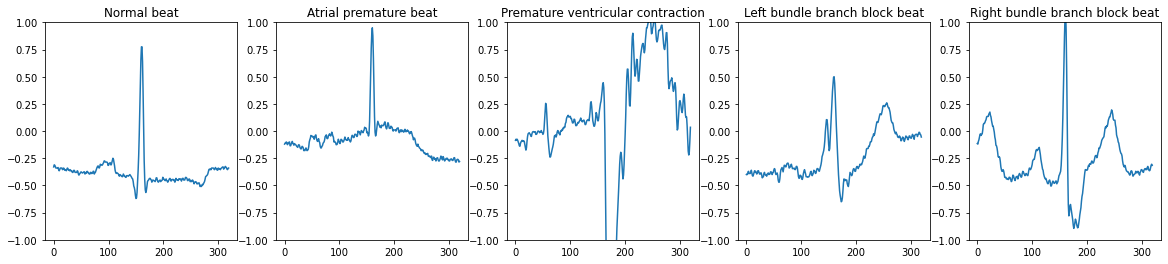

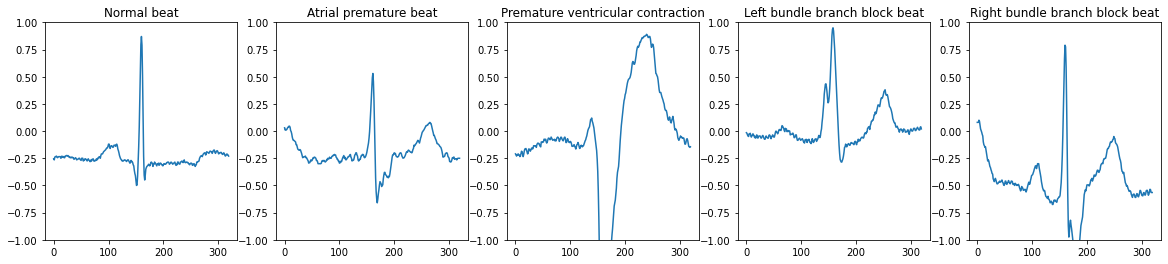

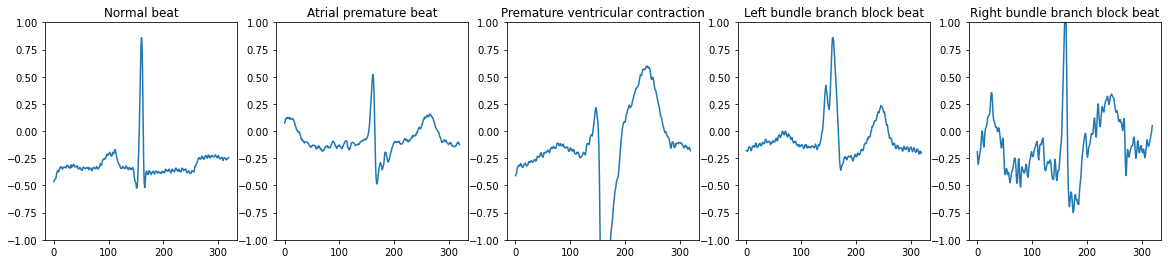

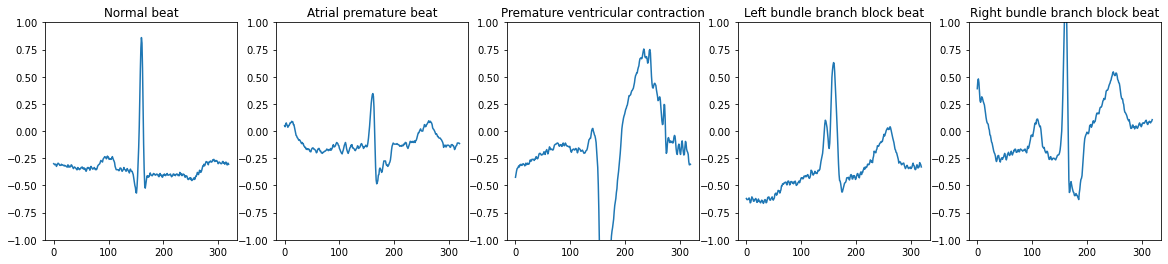

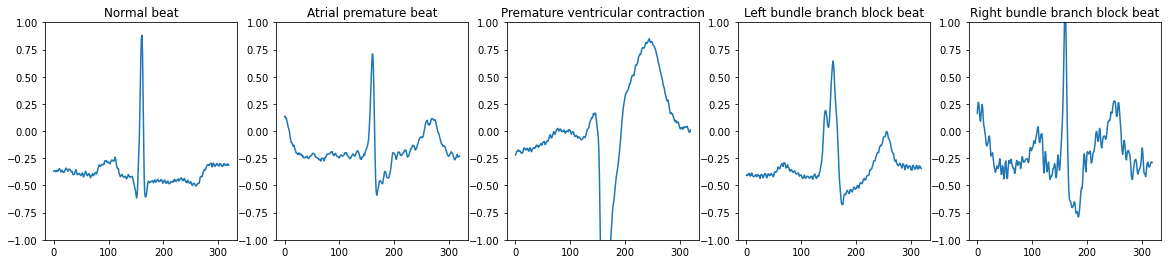

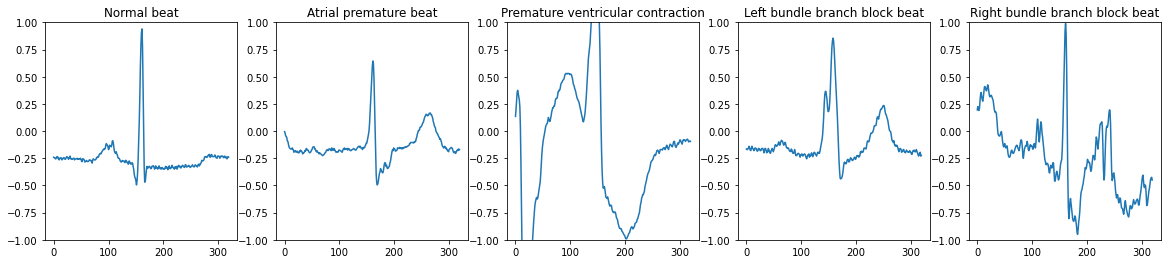

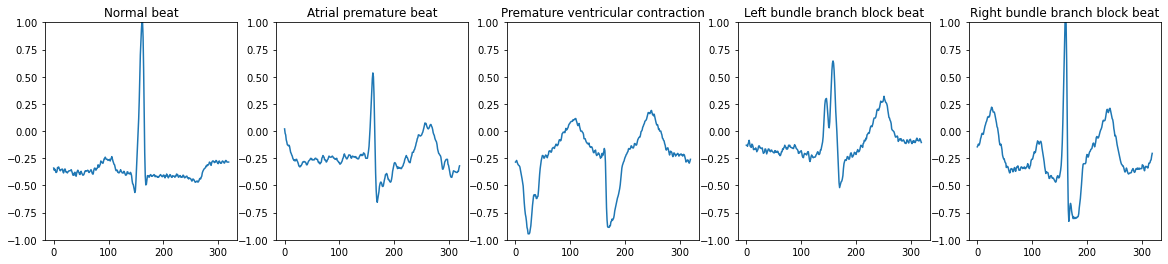

In [9]:
# Plot the signals
x = range(0, 320)
for i in range(0, 1000, 100):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))    
    ax1.set_title('Normal beat')
    ax1.plot(x, N_signals[i, :])
    ax1.set_ylim([-1, 1])
    ax2.set_title('Atrial premature beat')
    ax2.plot(x, A_signals[i, :])
    ax2.set_ylim([-1, 1])    
    ax3.set_title('Premature ventricular contraction')
    ax3.plot(x, V_signals[i, :])
    ax3.set_ylim([-1, 1])    
    ax4.set_title('Left bundle branch block beat')
    ax4.plot(x, L_signals[i, :])
    ax4.set_ylim([-1, 1])
    ax5.set_title('Right bundle branch block beat')
    ax5.plot(x, R_signals[i, :])
    ax5.set_ylim([-1, 1])    
    plt.show()

### Feature Extraction
<p>After extracting the signals from the MIT-BIH Database, the next step is to decompose the signals using Wavelets to extract the following features:</p>
<ul>
    <li>Mean values of each sub-band</li>
    <li>The standard deviation of each sub-band</li>
    <li>Median values of each sub-band</li>
    <li>The skewness of each sub-band</li>
    <li>Kurtosis of each sub-band</li>
    <li>Root mean square of each sub-band</li>
    <li>The ratio of each sub-band</li>
</ul>
<p>In order to do this, you can use the function <b><i>mitbih_processor.preprocessing.extract_features</i></b>, but before this, you have to define the next feature extraction parameters:</p>
<ul>
    <li><b>ECG signals:</b> the ECG signals loaded from the ecg_signals.mat file.</li>
    <li><b>Classification classes:</b> a list with the classes of the ECG signals (A, V, N, etc.).</li>
    <li><b>Signals per class:</b> how many signals per class for classification exist.</li>
    <li><b>Wavelet name:</b> the wavelet name.</li>
    <li><b>Decomposition level:</b> the decomposition level for the Wavelet decomposition.</li>
</ul>
<p>In this case, the signal class with the fewer number of examples is A (only 2546 signals in the ecg_signals.mat file) so this will value will be the signals per class parameter. The maximum decomposition level can be calculated with the library PyWavelets, an adequate decomposition level is one that does not generate infinite values of division by zero errors when Wavelet decomposition is being applied. Now I will perform feature extraction:</p>

In [10]:
# Import the required libraries
import pandas as pd
import pywt
from mitbih_processor import preprocessing

In [11]:
# Load the ecg_signals.mat file
ECG_signals = sio.loadmat('data/ecg_signals.mat')

In [12]:
# Define the feature extraction parameters
classes = 'A', 'V', 'N', 'L', 'R'
signals_per_class = 2546
wavelet_db1 = pywt.Wavelet('db1')
# By the next way, you can calculate the maximum decomposition level
# but this time we will use 6 instead.
#decomposition_level = pywt.dwt_max_level(
#    data_len=320,  # Each signal has 320 samples
#    filter_len=wavelet_db1.dec_len
#)
decomposition_level = 6

In [13]:
# Extract features
ext_feat_signals = preprocessing.extract_features(
    ECG_signals,         # The ECG signals from the ecg_signals.mat
    classes,             # The classification classes (A, V, N, L, R)
    signals_per_class,   # How many signals per class we have
    wavelet_db1,         # The Wavelet
    decomposition_level  # The decomposition level for the Wavelet decomposition
)

In [14]:
ext_feat_signals

,mean_a,mean_aa,mean_aaa,mean_aaaa,mean_aaaaa,mean_aaaaaa,mean_d,mean_dd,mean_ddd,mean_dddd,...,ratio_aaa/aaaa,ratio_aaaa/aaaaa,ratio_aaaaa/aaaaaa,ratio_aaaaaa/d,ratio_d/dd,ratio_dd/ddd,ratio_ddd/dddd,ratio_dddd/ddddd,ratio_ddddd/dddddd,classes
0,0.501250,0.708875,0.954064,1.308125,1.849968,2.616250,0.012816,0.011000,0.013347,0.014875,...,0.729337,0.707107,0.707107,204.134413,1.165119,0.824177,0.897253,0.751301,0.824958,0
1,0.517425,0.730000,0.995518,1.337375,1.891334,2.674750,0.012772,0.012250,0.015468,0.018875,...,0.744382,0.707107,0.707107,209.421051,1.042622,0.791960,0.819495,0.827699,0.707107,0
2,0.514597,0.727750,0.988977,1.341625,1.897344,2.683250,0.012861,0.013062,0.015203,0.018625,...,0.737149,0.707107,0.707107,208.642669,0.984536,0.859217,0.816257,0.816736,0.766528,0
3,0.516961,0.731094,0.995032,1.349063,1.907862,2.698125,0.011999,0.012094,0.014717,0.014938,...,0.737573,0.707107,0.707107,224.867770,0.992142,0.821773,0.985216,0.713074,0.801839,0
4,0.500808,0.704250,0.983320,1.256375,1.776783,2.512750,0.013037,0.011062,0.013347,0.016375,...,0.782665,0.707107,0.707107,192.735736,1.178511,0.828860,0.815062,0.805487,0.719622,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12725,0.394521,0.557938,0.740252,0.931875,1.260241,1.753250,0.016971,0.011250,0.014496,0.015750,...,0.794369,0.739442,0.718803,103.311247,1.508494,0.776093,0.920361,0.724353,0.797928,4
12726,0.413459,0.584719,0.772470,1.001313,1.350132,1.909375,0.016727,0.010469,0.012949,0.012937,...,0.771457,0.741640,0.707107,114.145903,1.597850,0.808467,1.000881,0.766341,0.730040,4
12727,0.383539,0.542219,0.701671,0.918313,1.277830,1.807125,0.016153,0.010469,0.013302,0.014563,...,0.764087,0.718650,0.707107,111.875707,1.542970,0.786979,0.913473,0.719458,0.732703,4
12728,0.365287,0.516031,0.681695,0.863688,1.168406,1.607125,0.016948,0.010781,0.013214,0.014188,...,0.789284,0.739202,0.727016,94.824218,1.572032,0.815892,0.931387,0.760726,0.749746,4


In [15]:
# I will save this DataFrame, in order to use it later
ext_feat_signals.to_csv('data/ecg_signals.preprocessed.csv', index=False)

<p>The data of features extracted are stored in a pandas DataFrame, each column has a meaningful name about what extracted features it contains. Wavelet decomposition results in nodes, A for approximation coefficients and D for detailed coefficients, this information is processed obtaining the mean, the standard deviation, the median, the skewness, the kurtosis, the root mean square, and the ratio of each sub-band, and then this information is saved in the columns of the DataFrame. 
    
The number of approximation coefficient nodes and detailed coefficient nodes depends on the decomposition level, if the level is 6, there will be 3 approximation coefficient nodes and 3 detailed coefficient nodes. That is the reason why the number of columns in the DataFrame with the extracted features changes when a different decomposition level is given.

I will print the column names so you can have a better understanding:</p>

In [16]:
for col in ext_feat_signals.columns:    
    print(f'- {col}')

- mean_a
- mean_aa
- mean_aaa
- mean_aaaa
- mean_aaaaa
- mean_aaaaaa
- mean_d
- mean_dd
- mean_ddd
- mean_dddd
- mean_ddddd
- mean_dddddd
- std_dev_a
- std_dev_aa
- std_dev_aaa
- std_dev_aaaa
- std_dev_aaaaa
- std_dev_aaaaaa
- std_dev_d
- std_dev_dd
- std_dev_ddd
- std_dev_dddd
- std_dev_ddddd
- std_dev_dddddd
- median_a
- median_aa
- median_aaa
- median_aaaa
- median_aaaaa
- median_aaaaaa
- median_d
- median_dd
- median_ddd
- median_dddd
- median_ddddd
- median_dddddd
- skewness_a
- skewness_aa
- skewness_aaa
- skewness_aaaa
- skewness_aaaaa
- skewness_aaaaaa
- skewness_d
- skewness_dd
- skewness_ddd
- skewness_dddd
- skewness_ddddd
- skewness_dddddd
- kurtosis_a
- kurtosis_aa
- kurtosis_aaa
- kurtosis_aaaa
- kurtosis_aaaaa
- kurtosis_aaaaaa
- kurtosis_d
- kurtosis_dd
- kurtosis_ddd
- kurtosis_dddd
- kurtosis_ddddd
- kurtosis_dddddd
- rms_a
- rms_aa
- rms_aaa
- rms_aaaa
- rms_aaaaa
- rms_aaaaaa
- rms_d
- rms_dd
- rms_ddd
- rms_dddd
- rms_ddddd
- rms_dddddd
- ratio_a/aa
- ratio_aa/aaa


<p>
The column "classes" in the DataFrame indicates what is the signal class of that row, as we provided the parameter classes as A, V, B, L, R, the 0 means A, 1 means V, and so then.
    
As we specified 2546 signals per class and A, V, N, L, and R for the classification classes, the rows from 0 to 2545 store extracted features for the A signals, the rows from 2546 to 5091 store extracted features for the V signals, the rows from 5092 to 7637 store extracted features for the N signals, the rows from 7638 to 10183 store extracted features for the L signals and the rows from 10184 to 12729 store extracted features for the R signals.</p>
### Classification
<p>The last step is to select a classification model, train it, and test it. In this case, I will use different classifiers and then make a comparison. In further works, the selection of the most important features could be applied.</p>

In [17]:
# Import the required libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
# Import the classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [18]:
# Read the DataFrame
ext_feat_signals = pd.read_csv('data/ecg_signals.preprocessed.csv')
X = ext_feat_signals[ext_feat_signals.columns.difference(['classes'])]
y = ext_feat_signals['classes']
classes = 'A', 'V', 'N', 'L', 'R'
# Split data in 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

In [19]:
class Classifier:
    def __init__(self, name=None, clf=None, accuracy=None, precision=None, recall=None, f1=None, cks=None, mcc=None):
        self.name = name
        self.clf = clf
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall
        self.f1 = f1
        self.cks = cks
        self.mcc = mcc


classifiers = [
    Classifier("Nearest Neighbors", KNeighborsClassifier(3)),
    Classifier("Linear SVM", SVC(kernel="linear", C=0.025)),
    Classifier("RBF SVM", SVC(gamma=2, C=1)),
    # Classifier("Gaussian Process", GaussianProcessClassifier(1.0 * RBF(1.0))),
    Classifier("Decision Tree", DecisionTreeClassifier(max_depth=5)),
    Classifier("Random Forest", RandomForestClassifier(max_depth=5, n_estimators=10)),
    Classifier("Neural Net", MLPClassifier(alpha=1, max_iter=1000)),
    Classifier("AdaBoost", AdaBoostClassifier()),
    Classifier("Naive Bayes", GaussianNB()),
    Classifier("QDA", QuadraticDiscriminantAnalysis()),
]

Classification Report For Nearest Neighbors

              precision    recall  f1-score   support

           A       0.81      0.87      0.84       736
           V       0.85      0.92      0.89       716
           N       0.99      0.95      0.97       754
           L       0.95      0.90      0.93       764
           R       0.97      0.92      0.94       849

    accuracy                           0.91      3819
   macro avg       0.91      0.91      0.91      3819
weighted avg       0.92      0.91      0.91      3819



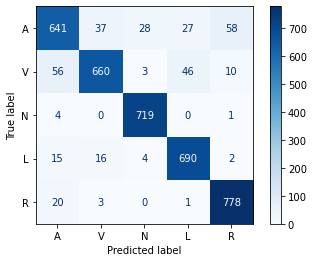

Classification Report For Linear SVM

              precision    recall  f1-score   support

           A       0.91      0.91      0.91       794
           V       0.91      0.94      0.93       749
           N       0.99      0.97      0.98       738
           L       0.97      0.96      0.97       734
           R       0.99      0.99      0.99       804

    accuracy                           0.95      3819
   macro avg       0.96      0.95      0.95      3819
weighted avg       0.95      0.95      0.95      3819



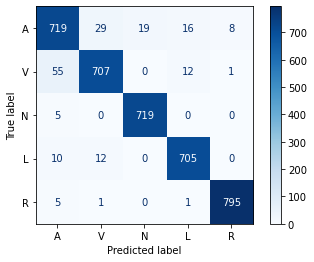

Classification Report For RBF SVM

              precision    recall  f1-score   support

           A       0.00      1.00      0.00         1
           V       0.01      1.00      0.02         8
           N       1.00      0.19      0.32      3807
           L       0.00      1.00      0.01         2
           R       0.00      1.00      0.00         1

    accuracy                           0.19      3819
   macro avg       0.20      0.84      0.07      3819
weighted avg       1.00      0.19      0.32      3819



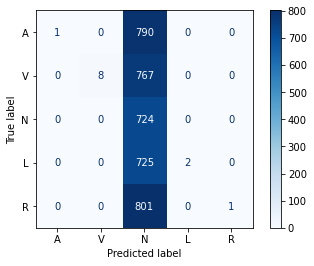

Classification Report For Decision Tree

              precision    recall  f1-score   support

           A       0.80      0.89      0.84       710
           V       0.91      0.78      0.84       904
           N       0.98      0.97      0.97       727
           L       0.86      0.92      0.89       681
           R       0.97      0.98      0.97       797

    accuracy                           0.90      3819
   macro avg       0.90      0.91      0.90      3819
weighted avg       0.91      0.90      0.90      3819



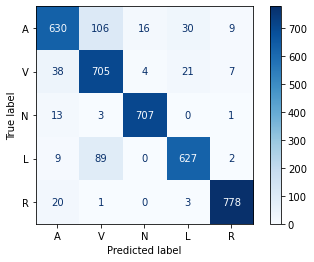

Classification Report For Random Forest

              precision    recall  f1-score   support

           A       0.90      0.94      0.92       762
           V       0.93      0.92      0.92       782
           N       0.99      0.97      0.98       744
           L       0.94      0.96      0.95       719
           R       0.99      0.98      0.99       812

    accuracy                           0.95      3819
   macro avg       0.95      0.95      0.95      3819
weighted avg       0.95      0.95      0.95      3819



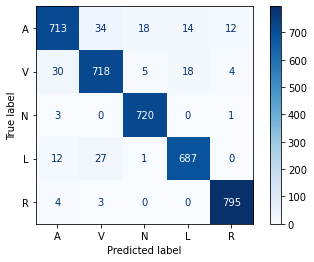

Classification Report For Neural Net

              precision    recall  f1-score   support

           A       0.91      0.94      0.93       763
           V       0.95      0.93      0.94       793
           N       0.98      0.97      0.98       737
           L       0.98      0.98      0.98       722
           R       0.99      0.99      0.99       804

    accuracy                           0.96      3819
   macro avg       0.96      0.96      0.96      3819
weighted avg       0.96      0.96      0.96      3819



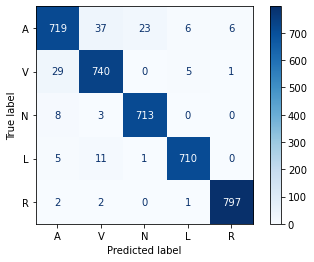

Classification Report For AdaBoost

              precision    recall  f1-score   support

           A       0.20      0.14      0.17      1160
           V       0.02      0.02      0.02       836
           N       0.98      0.95      0.97       746
           L       0.09      0.12      0.11       542
           R       0.54      0.81      0.65       535

    accuracy                           0.36      3819
   macro avg       0.37      0.41      0.38      3819
weighted avg       0.35      0.36      0.35      3819



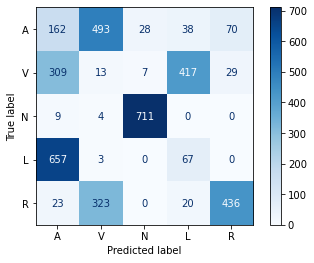

Classification Report For Naive Bayes

              precision    recall  f1-score   support

           A       0.81      0.90      0.85       717
           V       0.80      0.84      0.82       734
           N       0.96      0.97      0.97       717
           L       0.90      0.77      0.83       854
           R       0.98      0.99      0.99       797

    accuracy                           0.89      3819
   macro avg       0.89      0.89      0.89      3819
weighted avg       0.89      0.89      0.89      3819



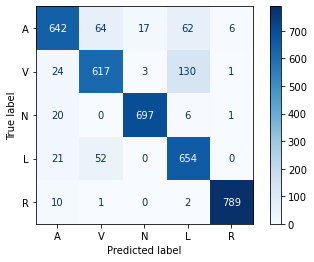

Classification Report For QDA

              precision    recall  f1-score   support

           A       0.92      0.91      0.92       795
           V       0.97      0.91      0.94       831
           N       0.97      0.98      0.98       716
           L       0.94      0.99      0.97       687
           R       0.98      1.00      0.99       790

    accuracy                           0.96      3819
   macro avg       0.96      0.96      0.96      3819
weighted avg       0.96      0.96      0.96      3819



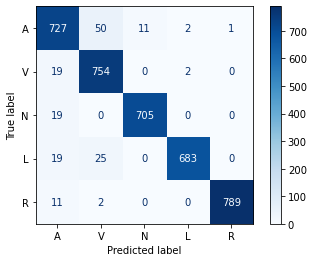

In [20]:
# Iterate over classifiers and show thier results
for clf_object in classifiers:
    # Train the model
    clf_object.clf.fit(X_train, y_train)
    # Predict
    y_pred = clf_object.clf.predict(X_test)
    # Calculate classification metrics
    clf_object.accuracy = np.round(metrics.accuracy_score(y_test, y_pred), 4)
    clf_object.precision = np.round(metrics.precision_score(y_test, y_pred, average='weighted'), 4)
    clf_object.recall = np.round(metrics.recall_score(y_test, y_pred, average='weighted'), 4)
    clf_object.f1 = np.round(metrics.f1_score(y_test, y_pred, average='weighted'), 4)
    clf_object.cks = np.round(metrics.cohen_kappa_score(y_test, y_pred))
    clf_object.mcc = np.round(metrics.matthews_corrcoef(y_test, y_pred))
    # Print the classification report and plot the confusion matrix
    print(f'Classification Report For {clf_object.name}\n')
    print(metrics.classification_report(y_pred, y_test, target_names=classes))
    metrics.plot_confusion_matrix(clf_object.clf, X_test, y_test, display_labels=classes, cmap=plt.cm.Blues)
    plt.show()

In [21]:
from IPython.display import HTML, display

rows = ""
for clf_object in classifiers:
    rows += f"""
    <tr>
        <td><b>{clf_object.name}</b></td>
        <td>{clf_object.accuracy}</td>
        <td>{clf_object.precision}</td>
        <td>{clf_object.recall}</td>
        <td>{clf_object.f1}</td>
        <td>{clf_object.cks}</td>
        <td>{clf_object.mcc}</td>
    </tr>
    """

html = HTML(f"""
<table>
<thead>
    <th>Algorithm</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1 Score</th>
    <th>Cohen Kappa Score</th>
    <th>Mathews Correlation Coefficient</th>
</thead>
<tbody>
{rows}
</tbody>
</table>
""")
display(html)

Nearest Neighbors,0.9133,0.9126,0.9133,0.9121,1.0,1.0
Linear SVM,0.9544,0.9543,0.9544,0.9543,1.0,1.0
RBF SVM,0.1927,0.8465,0.1927,0.0668,0.0,0.0
Decision Tree,0.9026,0.9067,0.9026,0.9029,1.0,1.0
Random Forest,0.9513,0.9511,0.9513,0.9511,1.0,1.0
Neural Net,0.9633,0.9633,0.9633,0.9632,1.0,1.0
AdaBoost,0.3637,0.4074,0.3637,0.3781,0.0,0.0
Naive Bayes,0.89,0.894,0.89,0.8904,1.0,1.0
QDA,0.9578,0.9592,0.9578,0.9581,1.0,1.0


<p>As you can see above, the best classification algorithms are Linear SVM, Neural Network, and QDA.</p>
<p><b><i>mitbih_processor</i></b> has also a functionality to describe a MIT-BIH Database record once you have a trained classifier. The information of the QRS Intervals is the following:</p>
<ul>
    <li><b>start_index:</b> the number of sample in the full signal of a record where the QRS Interval starts.</li>
    <li><b>end_index:</b> the number of sample in the full signal of a record where the QRS Interval ends.</li>
    <li><b>interval:</b> the QRS Interval itself (a segment of the full signal).</li>
    <li><b>class:</b> The class that interval was classified with.</li>
</ul>
<p>You can store this information for further analysis in a json file.
I will show an example of this functionality:</p>

In [22]:
# Import the required libaries
import numpy as np
import pandas as pd
import wfdb
import pywt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
%matplotlib inline
from mitbih_processor import describer

In [23]:
# Read the DataFrame
ext_feat_signals = pd.read_csv('data/ecg_signals.preprocessed.csv')
X = ext_feat_signals[ext_feat_signals.columns.difference(['classes'])]
y = ext_feat_signals['classes']
classes = 'A', 'V', 'N', 'L', 'R'
# Split data in 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)
# Get a classifier, in this case I will use Random Forest
clf = MLPClassifier(alpha=1, max_iter=1000)
clf.fit(X_train, y_train)

MLPClassifier(alpha=1, max_iter=1000)

In [24]:
# Read the record from MIT-BIH Arrhythmia Database
record_101 = wfdb.rdrecord('data/mitdb/101', channel_names=['MLII'])

# Get the QRS indices using `wfdb`
qrs_inds = wfdb.processing.xqrs_detect(sig=record_101.p_signal[:, 0], fs=record_101.fs, verbose=False)

# Define the feature extraction parameters, these must be the same values used for the training of the
# classifier
wavelet = pywt.Wavelet('db1')
decomposition_level = 6

# Extract the QRS Intervals
record_101_qrs_intervals = describer.get_qrs_intervals_with_classes(
    record_101,           # the record from MIT-BIH Arrhythmia Database
    qrs_inds,             # the QRS indices
    clf,                  # the trained classifier
    classes,              # the classes of the classifier
    decomposition_level,  # the decomposition level
    wavelet,              # the wavelet from pywt (this must be the same used for the training)
    320                   # the QRS Interval legth (320 is the recommended, this must be that same used for training)
)

There are: 
 - 215 QRS Intervals classified as A
 - 8 QRS Intervals classified as V
 - 1630 QRS Intervals classified as N
 - 8 QRS Intervals classified as L
 - 6 QRS Intervals classified as R



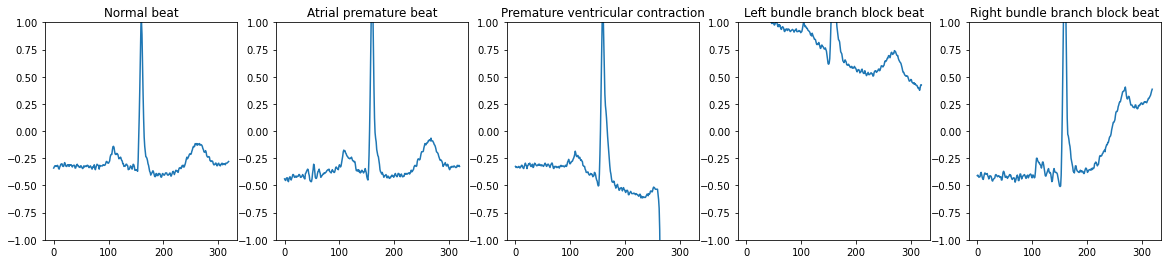

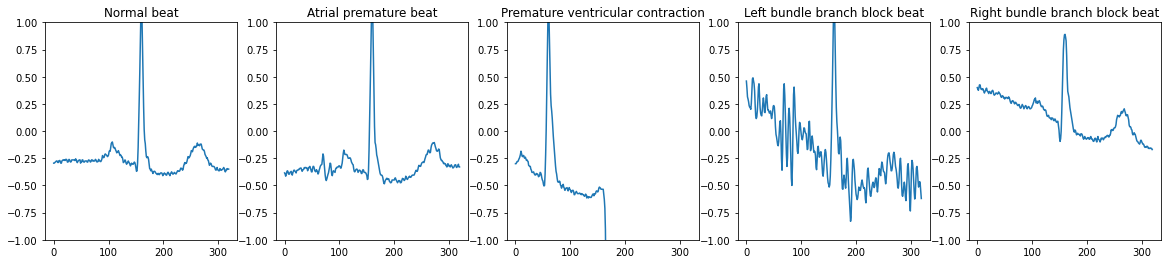

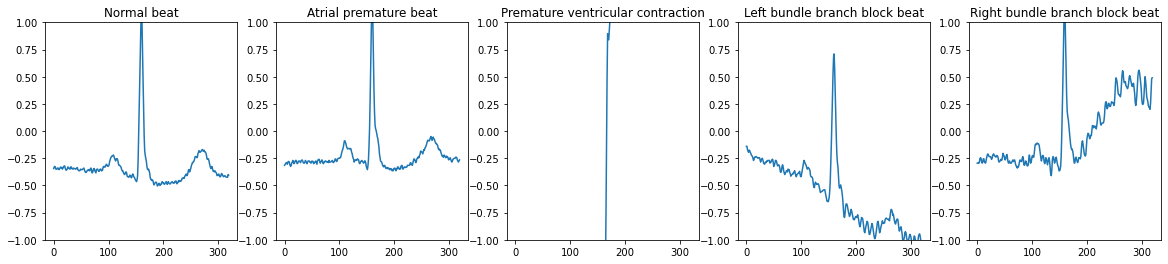

In [25]:
# Describe the QRS Intervals extracted
describer.describe_mitbih_record(record_101_qrs_intervals, classes)

# Plot some of the QRS Intervals
A_intervals = list(filter(lambda qrs_int: qrs_int.class_ == 'A', record_101_qrs_intervals))
V_intervals = list(filter(lambda qrs_int: qrs_int.class_ == 'V', record_101_qrs_intervals))
N_intervals = list(filter(lambda qrs_int: qrs_int.class_ == 'N', record_101_qrs_intervals))
L_intervals = list(filter(lambda qrs_int: qrs_int.class_ == 'L', record_101_qrs_intervals))
R_intervals = list(filter(lambda qrs_int: qrs_int.class_ == 'R', record_101_qrs_intervals))

x = range(0, 320)
for i in range(3):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))    
    ax1.set_title('Normal beat')
    ax1.plot(x, N_intervals[i].interval)
    ax1.set_ylim([-1, 1])
    
    ax2.set_title('Atrial premature beat')
    ax2.plot(x, A_intervals[i].interval)
    ax2.set_ylim([-1, 1])    
    
    ax3.set_title('Premature ventricular contraction')
    ax3.plot(x, V_intervals[i].interval)
    ax3.set_ylim([-1, 1])    
    
    ax4.set_title('Left bundle branch block beat')
    ax4.plot(x, L_intervals[i].interval)
    ax4.set_ylim([-1, 1])
    
    ax5.set_title('Right bundle branch block beat')
    ax5.plot(x, R_intervals[i].interval)
    ax5.set_ylim([-1, 1])    
    plt.show()